In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from scipy.sparse import issparse

/home/ahmad-maulana/Documents/project/Customer-Churn/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(os.path.join("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"))
print(df.shape)

(7043, 21)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


check class distribution

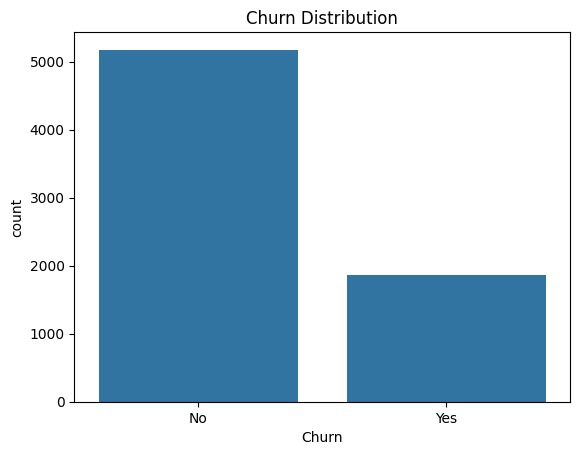

In [4]:
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution');

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


check each feature

In [6]:
inconsistent_multiplelines = df[(df['PhoneService'] == 'No') & (df['MultipleLines'] == 'Yes')]

if not inconsistent_multiplelines.empty:
    print("Inconsistent data found in 'MultipleLines' based on 'PhoneService':")
    print(inconsistent_multiplelines[['PhoneService', 'MultipleLines']])
else:
    print("No inconsistencies found in 'MultipleLines' based on 'PhoneService'.")

No inconsistencies found in 'MultipleLines' based on 'PhoneService'.


In [7]:
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Check for inconsistencies where InternetService is 'No' but any of the service_cols are 'Yes'
inconsistent_services = df[(df['InternetService'] == 'No') & 
                                 ((df[service_cols] == 'Yes').any(axis=1))]

if not inconsistent_services.empty:
    print("\nInconsistent data found where 'InternetService' is 'No' but other services are 'Yes':")
    print(inconsistent_services[['InternetService'] + service_cols])
else:
    print("\nNo inconsistencies found based on 'InternetService' being 'No'.")


No inconsistencies found based on 'InternetService' being 'No'.


In [8]:
col_names = df.columns
for col in col_names:
    print(f"{col}: {df[col].dtype}")
    print('value: ', df[col].unique())
    print('value count: ', len(df[col].unique()))
    print('na value count: ', df[col].isna().sum())
    print('empty value count: ', df[col].eq(' ').sum())
    print('duplicate value count: ', df[col].duplicated().sum())
    print("-"* 20, '\n')

customerID: object
value:  ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
value count:  7043
na value count:  0
empty value count:  0
duplicate value count:  0
-------------------- 

gender: object
value:  ['Female' 'Male']
value count:  2
na value count:  0
empty value count:  0
duplicate value count:  7041
-------------------- 

SeniorCitizen: int64
value:  [0 1]
value count:  2
na value count:  0
empty value count:  0
duplicate value count:  7041
-------------------- 

Partner: object
value:  ['Yes' 'No']
value count:  2
na value count:  0
empty value count:  0
duplicate value count:  7041
-------------------- 

Dependents: object
value:  ['No' 'Yes']
value count:  2
na value count:  0
empty value count:  0
duplicate value count:  7041
-------------------- 

tenure: int64
value:  [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 

# Issues

| Feature | Problem | Action |
| -------- | ------- | ------- |
| customerID | Just an ID, no predictive power | Drop |
| gender | Possibly predictive, maybe high bias | Keep, use SHAP to evaluate |
| SeniorCitizen | Encoded as 0 or 1 | Keep, use SHAP to evaluate |
| Partner | May correlate with curn, need to transform | Keep |
| Dependents | May correlate with curn, need to transform | Keep |
| tenure | Critical feature, need to transform | Categorize or bucket |
| PhoneService | May correlate with curn, need to transform | Keep |
| MultipleLines | May correlate with curn, need to transform | reduce the number of categories to binary |
| InternetService and others | Redundant "No internet service" and need to transform | Keep and transform |
| Contract | May high correlate with curn | Keep |
| PaperlessBilling | May correlate with curn, need to transform | Keep |
| PaymentMethod | May correlate with curn | Keep |
| MonthlyCharges | May critical feature | Keep |
| TotalCharges | May critical feature, contain empty data | Convert to numeric and fill empty data |
| Churn | Target variable | Use as target |

In [9]:
df.drop('customerID', axis=1, inplace=True) # Drop customerID as it is not needed for analysis
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') # Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'].fillna(df['TotalCharges'].median())

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

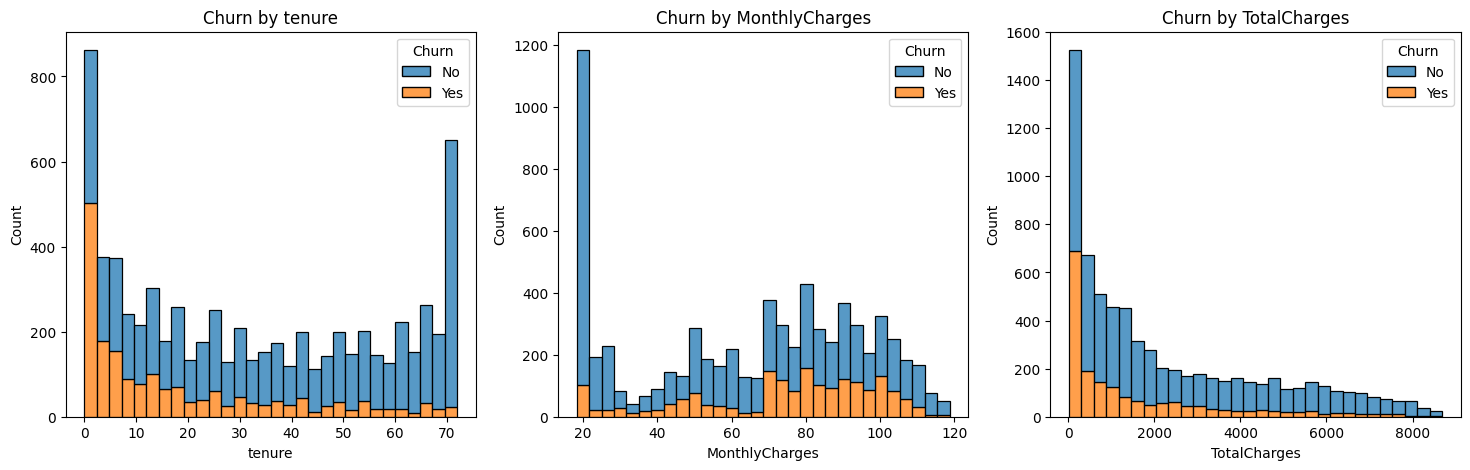

In [10]:
col = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i in range(len(col)):
    sns.histplot(data=df, x=col[i], hue='Churn', multiple='stack', bins=30, ax=axes[i])
    axes[i].set_title(f'Churn by {col[i]}')

1. The churn heavily concentrated among the new customers, while with the longer tenure are much less likely to churn.
2. Customers with low monthly charges (< $30) are more likely to stay than the higher charges (especially $70-$110) are associated with higher churn density, but the relationship is not stricly linear may caused by some high paying customers are loyal due to bundling, contracts or other reasons.
3. The total charges is strongly correlated with tenure and monthly charges. While it shows churned customers tend to have lower total charges than the retained customers, this may not add much signal beyond what tenure already provides. It may be predictive, but possibly redundant.

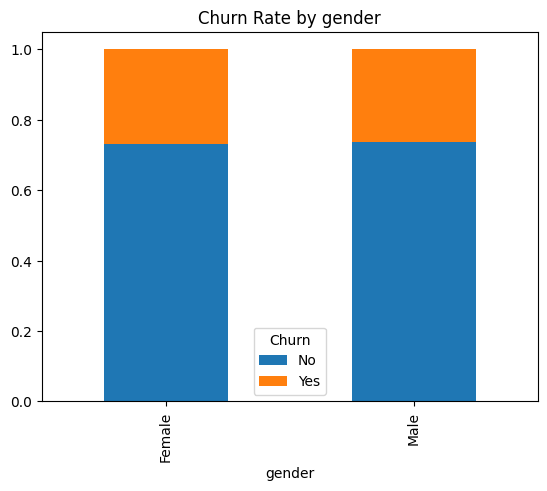

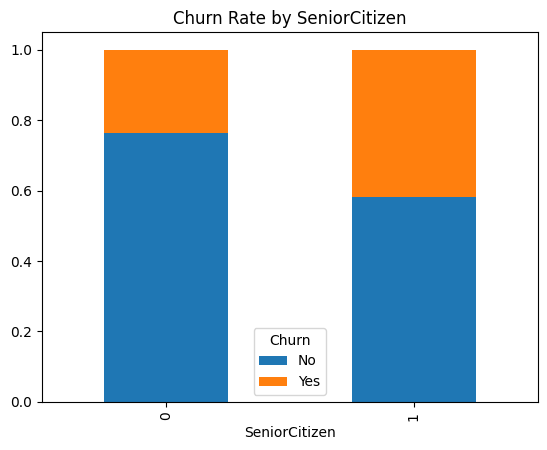

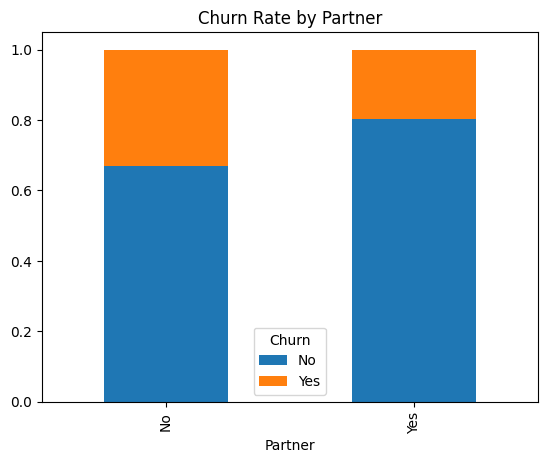

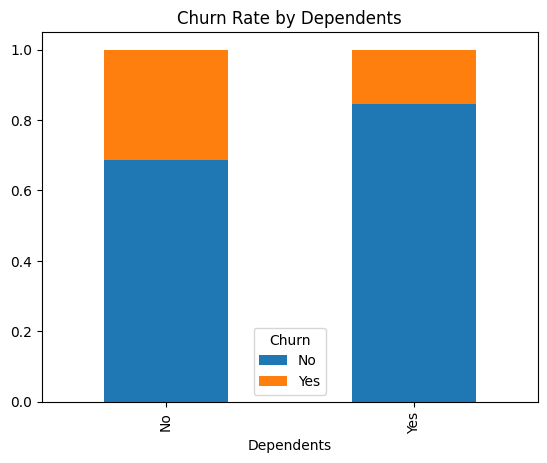

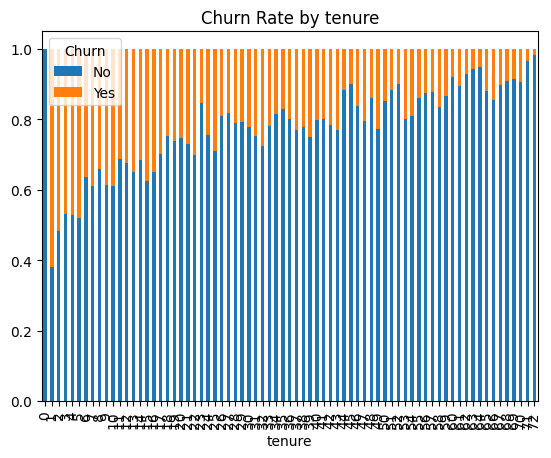

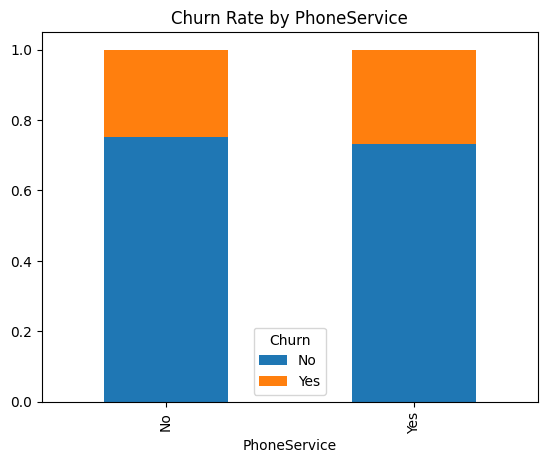

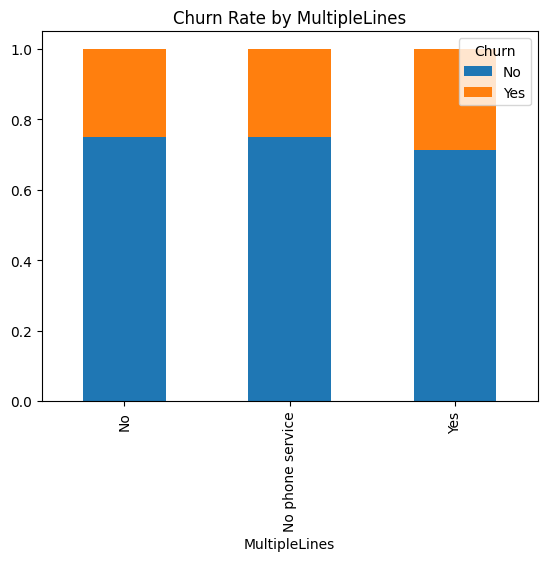

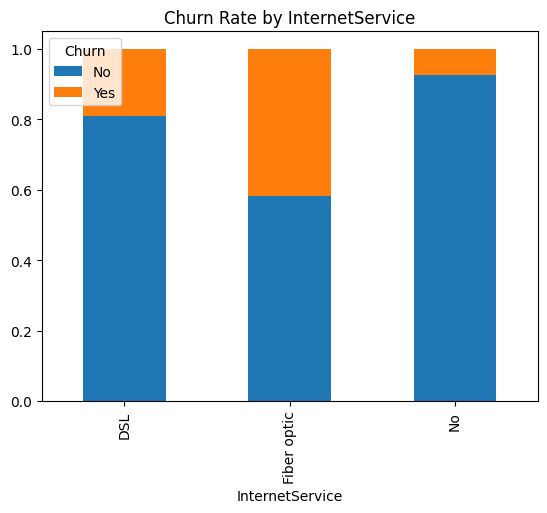

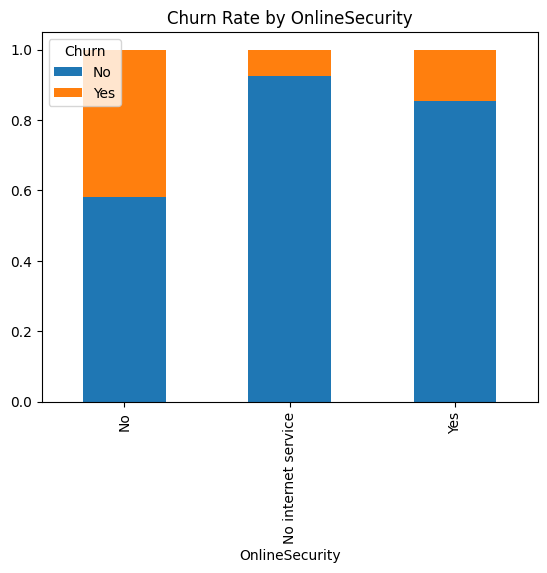

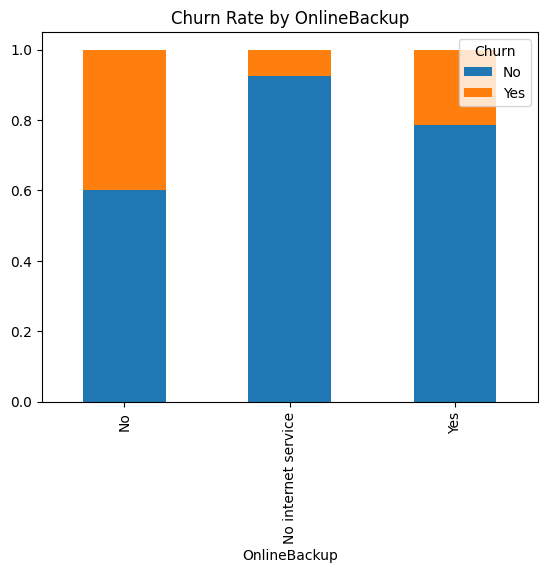

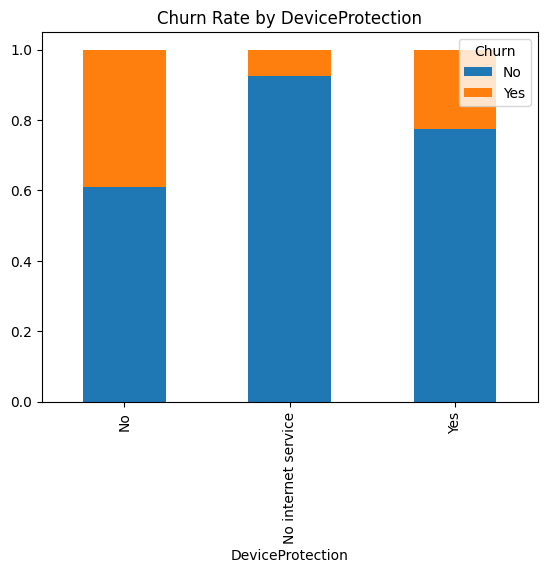

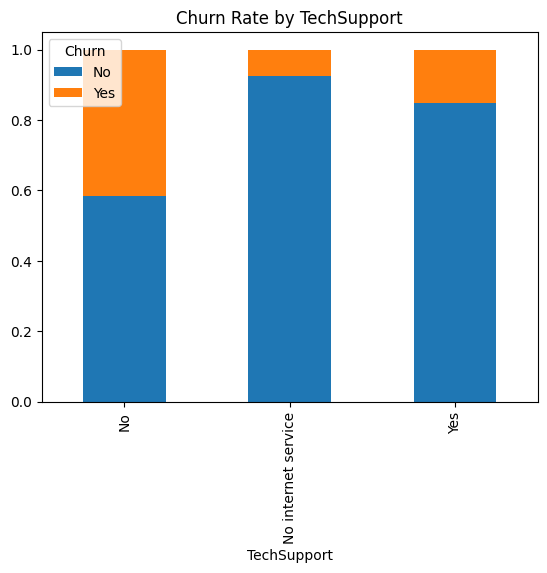

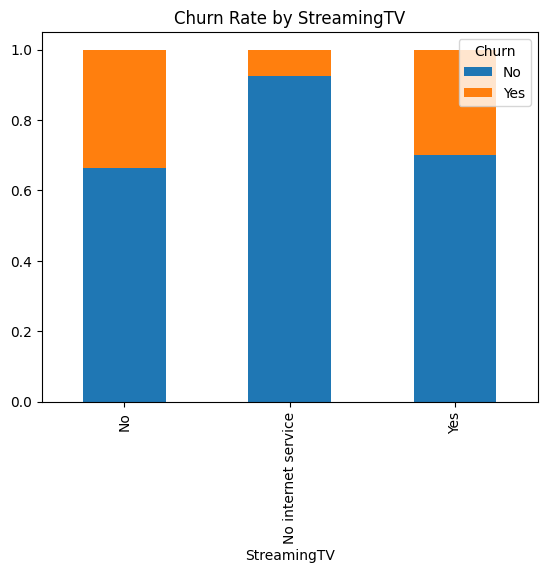

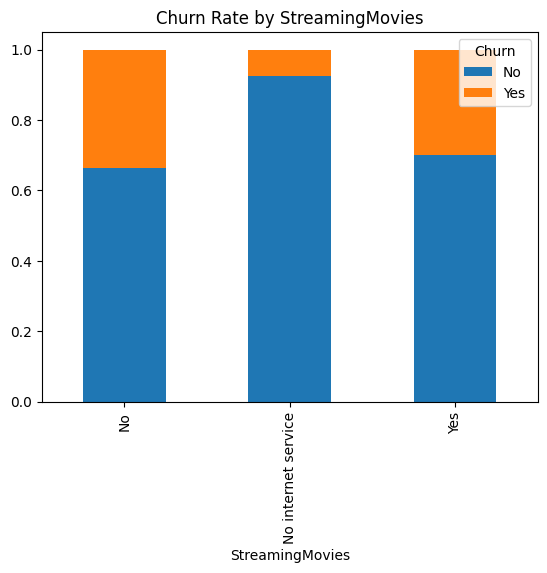

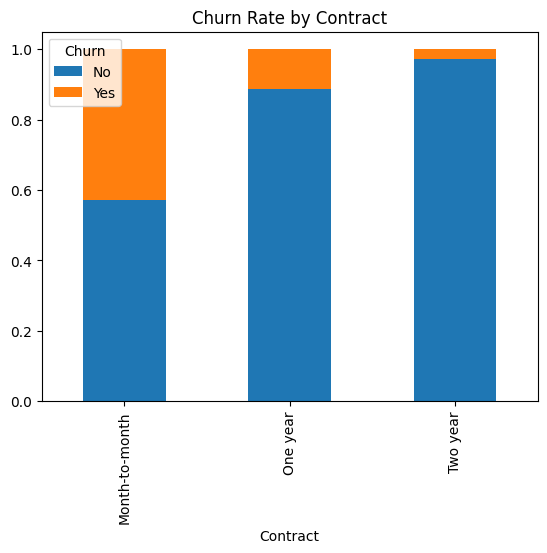

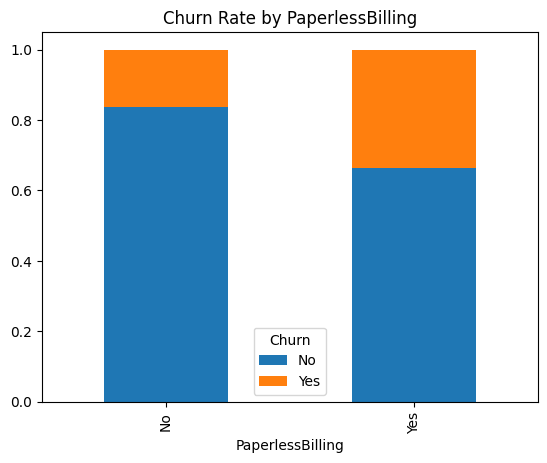

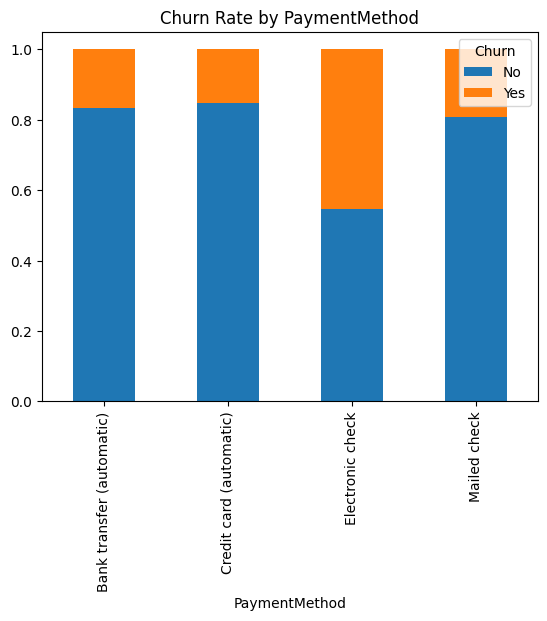

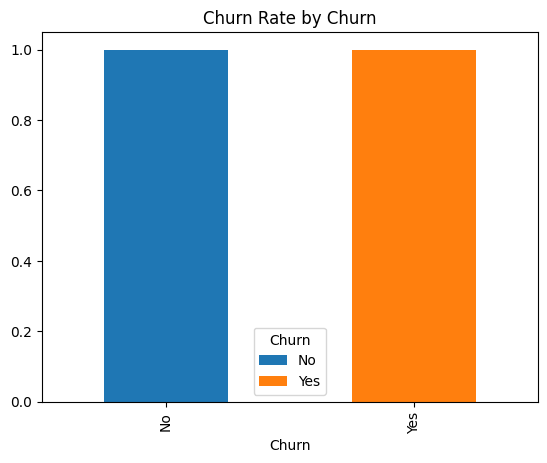

In [11]:
categorical_cols = df.select_dtypes(include=['int64', 'uint8', 'category', 'object']).columns
for col in categorical_cols:
    pd.crosstab(df[col], df['Churn'], normalize='index').plot(kind='bar', stacked=True)
    plt.title(f'Churn Rate by {col}')

In [12]:
categorical_cols = df.select_dtypes(include=['int64', 'uint8', 'category', 'object']).columns
categorical_cols = [col for col in categorical_cols if col != 'Churn']  # exclude target

from scipy.stats import chi2_contingency

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        continue  # skip degenerate tables (e.g., constant variables)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col} - Chi2: {chi2:.2f}, p-value: {p:.2e}")


gender - Chi2: 0.48, p-value: 4.87e-01
SeniorCitizen - Chi2: 159.43, p-value: 1.51e-36
Partner - Chi2: 158.73, p-value: 2.14e-36
Dependents - Chi2: 189.13, p-value: 4.92e-43
tenure - Chi2: 1065.33, p-value: 1.28e-176
PhoneService - Chi2: 0.92, p-value: 3.39e-01
MultipleLines - Chi2: 11.33, p-value: 3.46e-03
InternetService - Chi2: 732.31, p-value: 9.57e-160
OnlineSecurity - Chi2: 850.00, p-value: 2.66e-185
OnlineBackup - Chi2: 601.81, p-value: 2.08e-131
DeviceProtection - Chi2: 558.42, p-value: 5.51e-122
TechSupport - Chi2: 828.20, p-value: 1.44e-180
StreamingTV - Chi2: 374.20, p-value: 5.53e-82
StreamingMovies - Chi2: 375.66, p-value: 2.67e-82
Contract - Chi2: 1184.60, p-value: 5.86e-258
PaperlessBilling - Chi2: 258.28, p-value: 4.07e-58
PaymentMethod - Chi2: 648.14, p-value: 3.68e-140


Chi² and p-value only use for categorical data, not for numerical data

Strong Predictors of Churn (p-values < 0.05)
==

| Feature            | Chi2    | p-value   | Interpretation                                                |
| ------------------ | ------- | --------- | ------------------------------------------------------------- |
| `Contract`         | 1184.60 | 5.86e-258 | 🔥 **Strongest driver of churn**, The type of contract a customer has (likely month-to-month vs. longer term) dramatically affects churn probability. |
| `OnlineSecurity`   | 850.00  | 2.66e-185 | Strong indicator of customer engagement.|
| `TechSupport`      | 828.20  | 1.44e-180 | Technical support availability strongly influences retention.|
| `tenure`           | 1065.33 | 1.28e-176 | High tenure = low churn → makes sense.|
| `InternetService`  | 732.31  | 9.57e-160 | The type of internet service significantly impacts churn decisions, likely because "Fiber Optic" users churn more.|
| `PaymentMethod`    | 648.14  | 3.68e-140 | Auto vs manual methods impact churn.|
| `OnlineBackup`     | 601.81  | 2.08e-131 | Similar to OnlineSecurity — valuable feature.|
| `DeviceProtection` | 558.42  | 5.51e-122 | Engaged customers stay.|
| `StreamingMovies`  | 375.66  | 2.67e-82  | Value-added service retention signal.|
| `StreamingTV`      | 374.20  | 5.53e-82  | Value-added service retention signal.|
| `PaperlessBilling` | 258.28  | 4.07e-58  | Digital customers behave differently.|
| `Dependents`       | 189.13  | 4.92e-43  | Customers with dependents are less likely to churn.|
| `SeniorCitizen`    | 159.43  | 1.51e-36  | Older customers churn differently.|
| `Partner`          | 158.73  | 2.14e-36  | Married/living with someone → lower churn.|

Weak or Not Significant Predictors of Churn
==
| Feature        | Chi2 | p-value | Interpretation|
| ------- | ------- | ------- | ------- |
| `MultipleLines`    | 11.33   | 3.46e-03  | Statistically significant but much weaker than other factors.|
| `PhoneService` | 0.92 | 0.339   | Not statistically significant |
| `gender`       | 0.48 | 0.487   | No significant relationship with churn |


Text(0.5, 1.0, 'Feature Importance (Random Forest)')

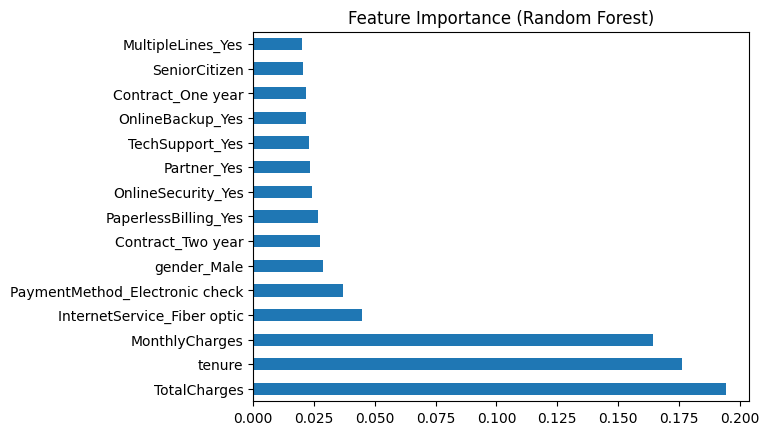

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical columns
X = df.drop(columns='Churn')
y = df['Churn']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Get feature importances
# Note: Feature names will be different after one-hot encoding
feature_names = (
    [f"{col}_{cat}" for col, cats in zip(categorical_cols, preprocessor.named_transformers_['cat'].categories_) for cat in cats[1:]] + numerical_cols
)

importances = pd.Series(
    model_pipeline.named_steps['classifier'].feature_importances_,
    index=feature_names
)

# Plot feature importances
importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importance (Random Forest)')


1. Features that align in both methods

| Feature                          | Chi² p-value | RF Importance | Verdict                 |
| -------------------------------- | ------------ | ------------- | ----------------------- |
| `tenure`                         | ≪ 0.01       | #2            | ✅ Strong and reliable   |
| `InternetService_Fiber Optic`    | ≪ 0.01       | #4            | ✅ Confirmed             |
| `PaymentMethod_Electronic check` | ≪ 0.01       | #5            | ✅ Consistent            |
| `Contract_Two year` / `One year` | ≪ 0.01       | #7, #13       | ✅ Confirmed             |
| `PaperlessBilling_Yes`           | ≪ 0.01       | #8            | ✅ Confirmed             |
| `OnlineSecurity_Yes`             | ≪ 0.01       | #9            | ✅ Confirmed             |
| `Partner_Yes`                    | ≪ 0.01       | #10           | ✅ Confirmed             |
| `TechSupport_Yes`                | ≪ 0.01       | #11           | ✅ Confirmed             |
| `OnlineBackup_Yes`               | ≪ 0.01       | #12           | ✅ Confirmed             |
| `SeniorCitizen`                  | ≪ 0.01       | #14           | ✅ Confirmed             |
| `MultipleLines_Yes`              | p = 0.003    | #15           | ✅ Reasonably consistent |

2. Contradictory features
- Gender_Male, RF might overfit to noise in gender. `Gender` only has 2 values and no theoretical reason to be related to affect churn.

data transformation

In [14]:
col_binary = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in col_binary:
  val = ['','']
  unique_value = df[col].unique()
  for value in unique_value:
    if value == 'Yes' or value == 1 or value == 'Female':
      val[1] = value
    elif value == 'No' or value == 0 or value == 'Male':
      val[0] = value
    else:
      print('error', value)
      break

  df[col] = df[col].map({val[1]: True, val[0]: False})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,True,False,True,False,1,False,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,False,False,False,False,34,True,No,DSL,Yes,No,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,False
2,False,False,False,False,2,True,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,False,False,False,False,45,False,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,True,False,False,False,2,True,No,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   bool   
 1   SeniorCitizen     7043 non-null   bool   
 2   Partner           7043 non-null   bool   
 3   Dependents        7043 non-null   bool   
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   bool   
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   bool   
 16  PaymentMethod     7043 non-null   object 


In [16]:
categorical_cols = df.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns
df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False)

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,True,False,True,False,1,False,True,29.85,29.85,False,...,True,False,False,True,False,False,False,False,True,False
1,False,False,False,False,34,True,False,56.95,1889.50,False,...,True,False,False,False,True,False,False,False,False,True
2,False,False,False,False,2,True,True,53.85,108.15,True,...,True,False,False,True,False,False,False,False,False,True
3,False,False,False,False,45,False,False,42.30,1840.75,False,...,True,False,False,False,True,False,True,False,False,False
4,True,False,False,False,2,True,True,70.70,151.65,True,...,True,False,False,True,False,False,False,False,True,False


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   bool   
 1   SeniorCitizen                            7043 non-null   bool   
 2   Partner                                  7043 non-null   bool   
 3   Dependents                               7043 non-null   bool   
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   bool   
 6   PaperlessBilling                         7043 non-null   bool   
 7   MonthlyCharges                           7043 non-null   float64
 8   TotalCharges                             7032 non-null   float64
 9   Churn                                    7043 non-null   bool   
 10  MultipleLines_No                         7043 no

SHAP

In [18]:
import graphviz
import scipy
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [19]:
pred = model.predict(X_test)

explainer = shap.TreeExplainer(model)
explaination = explainer(X_test)

In [20]:
shap_values = explaination.values
# Select SHAP values for the positive class (Churn=True)
shap_values_positive = shap_values[:, 1]
# Select base values for the positive class
base_values_positive = explaination.base_values[:, 1]
np.abs(shap_values_positive.sum(axis=1) + base_values_positive - pred).max()

np.float64(0.7346858359957408)

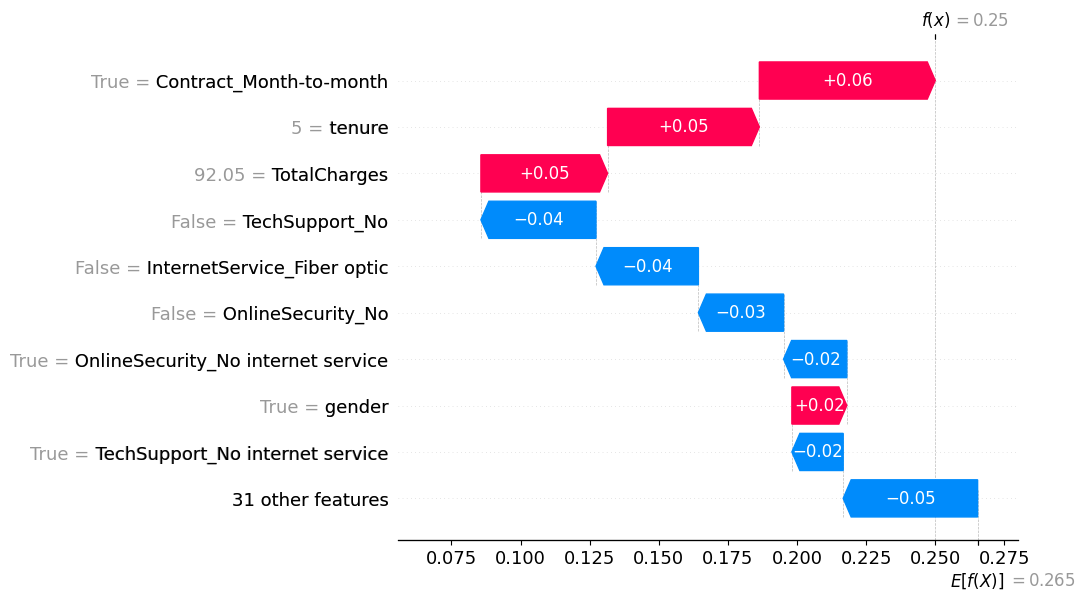

The real value is False


In [21]:
id = np.random.randint(0, explaination.shape[0])

shap.plots.waterfall(explaination[id,:,1])

print(f'The real value is {y_test.iloc[id]}')